<a href="https://colab.research.google.com/github/lopesmatheus/COA19-PythonSimu/blob/DQN/main_discrete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic?hl=fr

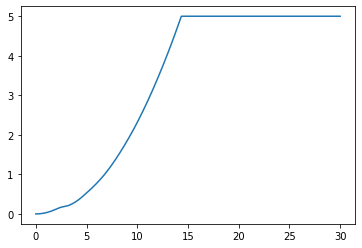

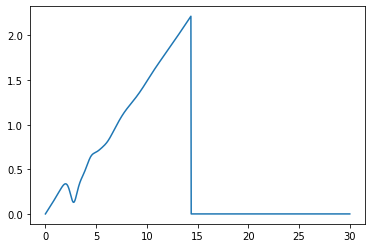

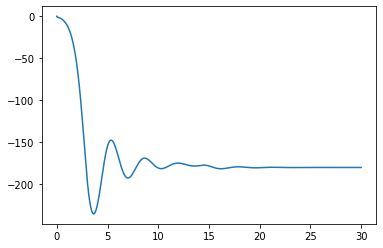

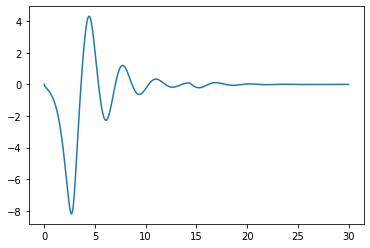

In [ ]:
import numpy as np
from scipy.integrate import odeint

class CarPend:
    def __init__(self):
        self.M = 400/1000
        self.m = 50/1000
        self.action_set = np.array([-1,-0.5,0,0.5,1])
        self.dt = 0.01
        
        self.L = 0.3
        
        self.x = 0
        self.xp = 0
        self.xpp = 0
        
        self.theta = 0
        self.thetap = 0
        self.thetapp = 0
        
    def reset(self):
        self.x = 0
        self.xp = 0
        
        self.theta = np.random.uniform(-np.pi/100., np.pi/100.)
        self.thetap = np.random.uniform(-0.1,0.1)

        state = [self.x,self.xp,self.theta,self.thetap]
        return np.array(state)

    def dynamic_mod(self,x0,t,f):
        x1,x2,x3,x4 = x0
        tol = 10**(-6)
        er = 1
        g = 9.81
        b = 0.01
        
        dx2dt_old = self.xpp
        dx4dt_old = self.thetapp
        
        while er>tol:
            if abs(x1)>=5:
                dx2dt = 0
            else:
                dx2dt = f - dx4dt_old * self.m * self.L * np.cos(x3) + self.m * self.L * (x4**2) * np.sin(x3) / (self.M + self.m)
            
            dx4dt = (self.m * g * self.L * np.sin(x3) - self.m * self.L * np.cos(x3) * dx2dt - b*x4) / (self.m * self.L**2)
            
            er = max(abs(dx2dt - dx2dt_old),abs(dx4dt - dx4dt_old))
            
            dx2dt_old = dx2dt
            dx4dt_old = dx4dt
        
        self.xpp = dx2dt
        self.thetapp = dx4dt
            
        return np.array([x2,dx2dt,x4,dx4dt])
    
    def step(self,action_index):
    
        x0 = np.array([self.x,self.xp,self.theta,self.thetap])
        f = self.action_set[action_index]
        
        sol = odeint(self.dynamic_mod,x0,[0,self.dt],args=(f,))
        
        self.x = sol[-1,0]
        self.x = max(self.x,-5)
        self.x = min(self.x, 5)
        
        if abs(self.x)>=5:
            self.xp = 0
        else:
            self.xp = sol[-1,1]
        
        self.theta = sol[-1,2]
        self.thetap = sol[-1,3]
        
        state = [self.x,self.xp,self.theta,self.thetap]
        
        if abs(self.x)<=2.5 and abs(self.theta)<=15*np.pi/180:
            done = False
            reward = 1
        else:
            done = True
            reward = 0
            
        return np.array(state), reward, done

import matplotlib.pyplot as plt

tf = 30;
N = int(10/0.01) + 1

t = np.linspace(0,tf,N)

x = np.zeros(N)
xp = np.zeros(N)
xpp = np.zeros(N)
theta = np.zeros(N)
thetap = np.zeros(N)

Car = CarPend()
Car.reset()

for i in range(0,N-1):
    
    state,reward,done = Car.step(3)

    x[i+1] = state[0]
    xp[i+1] = state[1]
    xpp[i] = Car.xpp
    theta[i+1] = state[2]
    thetap[i+1] = state[3]
    

plt.figure()
plt.plot(t,x)

plt.figure()
plt.plot(t,xp)

plt.figure()
plt.plot(t,theta*180/np.pi)

plt.figure()
plt.plot(t,thetap)

#plt.figure()
#plt.plot(t,xpp)

plt.show()

In [ ]:
import numpy as np
from itertools import count
from collections import namedtuple
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
# Importing PyTorch here




In [ ]:
!pip install fmpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 KB 11.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import shutil
import pandas as pd

In [ ]:
from fmpy import read_model_description, extract
from fmpy.fmi2 import FMU2Slave
from A_T01a import A_T01a
import numpy as np
import shutil
import pandas as pd

In [ ]:
# define the model name and simulation parameters

class PlantEnv:
    def __init__(self,CaseTest,Hysteresis,step_size):
        self.action_scale=300
        self.Hysteresis = Hysteresis
        #self.action_set = np.array(range(-50,50,1))
        self.CaseTest = CaseTest
        
        #self.action_space = gym.spaces.Box(0,1000,(1,),np.float64)
        self.observation_space=gym.spaces.Box(np.array([-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0]),np.array([1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0]),(10,),np.float64)

        fmu_plant_filename = 'PLANT_v3_linux.fmu'
        self.step_size = step_size
        
        self.Tend = self.CaseTest.getTsimu() - self.CaseTest.getTend()

        # read the model description
        plant_description = read_model_description(fmu_plant_filename)

        # collect the value references
        self.plant_vrs = {}
        for variable in plant_description.modelVariables:
            self.plant_vrs[variable.name] = variable.valueReference

        self.inputs_plant = [v for v in plant_description.modelVariables if v.causality == 'input']
        self.outputs_plant = [v for v in plant_description.modelVariables if v.causality == 'output']

        input_plant_order = []
        
        for v in self.inputs_plant:
            input_plant_order.append(v.valueReference)

        self.CaseTest.setInputOrder(input_plant_order)

        # extract the FMU
        self.unzipdir_plant = extract(fmu_plant_filename)

        self.fmu_plant = FMU2Slave(guid=plant_description.guid,
                             unzipDirectory=self.unzipdir_plant,
                             modelIdentifier=plant_description.coSimulation.modelIdentifier,
                             instanceName='instance1')

        # initialize
        self.fmu_plant.instantiate()
        self.fmu_plant.setupExperiment(startTime=0)
        self.fmu_plant.enterInitializationMode()
        self.fmu_plant.exitInitializationMode()
        
        self.fmu_plant.setReal([self.inputs_plant[1].valueReference], [self.Hysteresis])       # HYSTERESIS 
        
        for cst in self.CaseTest.getConstantsInputs():
            vr = self.inputs_plant[cst].valueReference
            self.fmu_plant.setReal([vr], [self.CaseTest.getAll(vr,0)])
            
        self.counter = 0
        self.time = 0
        self.state=np.zeros((10,))
        
    def reset(self):
        self.fmu_plant.reset()
        self.fmu_plant.setupExperiment(startTime=0)
        self.fmu_plant.enterInitializationMode()
        self.fmu_plant.exitInitializationMode()
        
        self.fmu_plant.setReal([self.inputs_plant[1].valueReference], [self.Hysteresis])       # HYSTERESIS 
        
        for cst in self.CaseTest.getConstantsInputs():
            vr = self.inputs_plant[cst].valueReference
            self.fmu_plant.setReal([vr], [self.CaseTest.getAll(vr,0)])
            
        self.counter = 0
        self.time = 0
        self.state=np.zeros((10,))
        return(self.state)
        
    def step(self, action,prev):
        for var in self.CaseTest.getVariablesInputs():
            vr = self.inputs_plant[var].valueReference
            self.fmu_plant.setReal([vr], [self.CaseTest.getAll(vr,self.counter)])
        self.fmu_plant.setReal([self.inputs_plant[0].valueReference], [action])

        self.fmu_plant.doStep(currentCommunicationPoint=self.time, communicationStepSize=self.step_size)
        
        self.counter += 1
        self.time += self.step_size
        
        if self.time < self.Tend:
            done = False
        else:
            done = True

        for i in range(self.state.shape[0]-1):
          self.state[i]=self.state[i+1]


        TBAS_SENSOR = self.fmu_plant.getReal([self.outputs_plant[4].valueReference])[0]
        FAV_POSITION_DEG = self.fmu_plant.getReal([self.outputs_plant[0].valueReference])[0]
        
        T_target = self.CaseTest.getT_tgt_C()
        
        error = (TBAS_SENSOR - T_target[0])**2

        reward = - error**2#- max(self.time-60,0)/(self.time+1) * max(error-10,0) -  max(self.time-120,0) * max(error-5,0)/(self.time+1)  
        self.state[9]=TBAS_SENSOR
        return self.state, reward, done, _
    
    def kill_plant(self):
        self.fmu_plant.terminate()
        self.fmu_plant.freeInstance()

        # clean up
        shutil.rmtree(self.unzipdir_plant, ignore_errors=True)

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

cuda


In [ ]:
# You can move either left or right to balance the pole
# Lets implement the Actor critic network
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        #self.fc1 = nn.Linear(10, 128) # 4 because there are 4 parameters as the observation space
        #self.actor = nn.Sequential(Linear(128, 5) # 5 for the number of actions
                                   #.to(device=self.device).float()
        self.device=DEVICE  
        self.actor = nn.Sequential(nn.Linear(10, 128), nn.ReLU(),
                            nn.Linear(128, 128), nn.ReLU(),
                            nn.Linear(128, 50)).to(device=self.device).float()
        self.critic = nn.Sequential(nn.Linear(10, 128), nn.ReLU(),
                            nn.Linear(128, 128), nn.ReLU(),
                            nn.Linear(128, 1),nn.Tanh()).to(device=self.device).float()
                 
        #self.critic = nn.Linear(128, 1) # Critic is always 1
        self.saved_actions = []
        self.rewards = []
        self.to(self.device)

    # def forward(self, x):
    #     #x = F.relu(self.fc1(x))
    #     action_prob = self.actor(x) #F.softmax(self.actor(x), dim=-1) ##for probability
    #     state_values = self.critic(x)
    #     return action_prob, state_values
        
    def select_action(self,state,prev):
          state = torch.tensor(state, dtype=torch.float).to(self.device)
          #state = torch.from_numpy(state).float()
          probs =self.actor.forward(state).to(self.device)
          print(probs)
          probs= F.softmax(probs, dim=0)
          state_value=self.critic.forward(state).to(self.device)
          print(probs)
          m = Categorical(probs)
          action = m.sample()
          self.saved_actions.append(SavedAction(m.log_prob(action), state_value))
          return action
        
# Note that this is equivalent to what used to be called multinomial


        # next_state, reward = env.step(action)
        # loss = -m.log_prob(action) * reward
        # loss.backward()
        
        
        # return action.cpu().detach().numpy()

In [ ]:
def finish_episode():
    # We calculate the losses and perform backprop in this function
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses =[]
    returns = []
    
    for r in model.rewards[::-1]: ## On remonte à l'envers, on part du dernier
        R = r + 0.99 * R # 0.99 is our gamma number
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    
    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()
 
        # policy_losses.append(-log_prob.cpu().detach().numpy() * advantage.cpu().detach().numpy())
        # value_losses.append(F.smooth_l1_loss(value, torch.tensor([R]).to(DEVICE)))
        policy_losses.append(-log_prob*advantage)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R]).to(DEVICE)))

    
    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    
    loss.backward()
    optimizer.step()
    
    del model.rewards[:]
    del model.saved_actions[:]

https://gist.github.com/programming-datascience/d8b96346e347b0b6942e16a33e64039c

In [ ]:
def train(env,model):
    running_reward = 10
    for i_episode in range(10000): # We need around this much episodes
        state = env.reset()
        ep_reward = 0
        prev=0
        for t in range(1, 10000):
            action = max(model.select_action(state,prev).cpu().detach().numpy()-25 +prev,0)
            print(action)
            state, reward, done, _ = env.step(action,prev)
            prev=action
            model.rewards.append(reward)
            ep_reward += reward
            if done:
                break
        running_reward = 0.05 * ep_reward + (1-0.05) * running_reward
        finish_episode()
        # if i_episode % 10 == 0: # We will print some things out
        print("Episode {}\tLast Reward: {:.2f}\tAverage reward: {:.2f}".format(
                i_episode, ep_reward, running_reward
            ))


                  

In [ ]:
model = ActorCritic()
optimizer = optim.Adam(model.parameters(), lr=3e-2)
eps = np.finfo(np.float32).eps.item()
step_size = 10
CaseTest = A_T01a(step_size)
environment = PlantEnv(CaseTest,0.0,step_size)
train(environment,model)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 6.2485e-28, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.2659e-31,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00], device='cuda:0', grad_fn=<SoftmaxBackward0>)
179
tensor([ -47.7427,  -30.9928,   25.7596,   55.7508,   71.1476, -152.8049,
          63.0350,   23.6738,  -15.2033, -220.0515,   35.5651,   56.5625,
          82.8795, -174.3705, -247.2638,   86.0722, 

KeyboardInterrupt: ignored

In [ ]:
# There. we finished
# Lets see it in action
import matplotlib.pyplot as plt


step_size = 10
CaseTest = A_T01a(step_size)
cartpole = PlantEnv(CaseTest,0.0,step_size)

done = False
cnt = 0
observation = cartpole.reset()
prev=0
t=[]
x=[]
xp=[]
th=[]
thp=[]
actions=[]
while not done :
    cnt += 1
    t.append(cnt)
    #print(cartpole.state)
    #print(model.select_action(observation,prev).cpu().detach().numpy())
    print(model.select_action(observation,prev).cpu().detach().numpy())
    print(prev)
    action=max(model.select_action(observation,prev).cpu().detach().numpy()-50 +prev,0)
    print(action)
    #action =max(cnt-1000,0)
    #print(action)
   # print(action.cpu().detach().numpy())
    actions.append(action)
    observation, reward, done,_ = cartpole.step(action,prev)
    prev=action
    x.append(observation[9])
    #xp.append(observation[1])
    #th.append(observation[2])
    #thp.append(observation[3])



    # Lets see how long it lasts until failing


plt.figure()
plt.plot(t,x)
plt.plot(t,[CaseTest.getT_tgt_C() for i in range(310)])
plt.xlabel('t (step)')
plt.ylabel('x')


# plt.figure()
# plt.plot(t,xp)
# plt.xlabel('t (step)')
# plt.ylabel('v')

# plt.figure()
# plt.plot(t,np.array(th)*180/np.pi)
# plt.xlabel('t (step)')
# plt.ylabel('theta')

# plt.figure()
# plt.plot(t,thp)
# plt.xlabel('t (step)')
# plt.ylabel('theta point')
# #plt.figure()
#plt.plot(t,xpp)

plt.show()
print(x)
plt.plot(t,actions)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.1007e-27,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00], device='cuda:0', grad_fn=<SoftmaxBackward0>)
0
tensor([ -80.0726,  -40.9059,   30.9283,   60.6735,  105.8806, -251.9620,
          86.4515,   15.5216,  -41.6855, -322.8063,   45.7529,   79.8637,
         129.9658, -252.0054, -348.7134,  129.4073, -187.9722,    8.9802,
         108.0196, -164.0351, -561.9012,  387.9824,  426.6690, -371.0314,
         113.5067, -186.0571,  124.1164, -101.9212,   -3.2622, -30

In [ ]:
# There. we finished
# Lets see it in action
cartpole=CarPend()
done = False
cnt = 0
observation = carpole.reset()
t=[]
x=[]
xp=[]
th=[]
thp=[]
while not done :
    cnt += 1
    t.append(cnt)

    action = select_action(observation)
    observation, reward, done = carpole.step(action)
    x.append(observation[0])
    xp.append(observation[1])
    th.append(observation[2])
    thp.append(observation[3])



    # Lets see how long it lasts until failing


plt.figure()
plt.plot(t,x)
plt.xlabel('t (step)')
plt.ylabel('x')

plt.figure()
plt.plot(t,xp)
plt.xlabel('t (step)')
plt.ylabel('v')

plt.figure()
plt.plot(t,np.array(th)*180/np.pi)
plt.xlabel('t (step)')
plt.ylabel('theta')

plt.figure()
plt.plot(t,thp)
plt.xlabel('t (step)')
plt.ylabel('theta point')
#plt.figure()
#plt.plot(t,xpp)

plt.show()

NameError: ignored